## 2. Acquire the Data

We have downloaded the data from https://www.backblaze.com/hard-drive-test-data.html

**Data Formats**
- csv files

As the files are related, instead of reading everything file by file, its better to offload this data into a 
simple database so that we can query on the data easily.

**Database**
- SQLite



# Creating entries in SQLite using pandas and sqlalchemy

In [ ]:
import pandas as pd
from sqlalchemy import create_engine
import os

In [ ]:
path = os.path.join(os.getcwd(),'data')

In [ ]:
engine = create_engine('sqlite:////home/nischal/hard-disk-reduced.db')
#engine = create_engine('sqlite:////Users/standy/hard-disk.db')



In [ ]:
total_rows = 0
inp_df = pd.DataFrame()
no_of_files = 0
total_files = len(os.listdir(path))
file_counter = 0
for file in os.listdir(path):
    
    no_of_files = no_of_files + 1
    file_counter = file_counter + 1
    print no_of_files,file_counter
    inp_temp_df = pd.read_csv(os.path.join(path,file))
    
    if inp_df.shape[0] == 0:
        inp_df = inp_temp_df
    else:
        inp_df = inp_df.append(inp_temp_df)
    
    if no_of_files == 3 or file_counter == total_files:
        no_of_files = 0
        inp_df.to_sql("data",engine,index=False,chunksize=None,if_exists='append')
        inp_df = pd.DataFrame()

    total_rows = total_rows + inp_temp_df.shape[0]

print 'loading data done with rows '+str(total_rows)

# Now the data is sitting inside SQLite, let us start refining the data

Now let us read what are the column names

In [ ]:
total_df = pd.read_sql_query(sql='''SELECT  from data limit 2000000''' ,con=engine)

In [ ]:
total_df.fillna(0,inplace=True)

In [ ]:
from scipy.stats import pearsonr
import numpy as np

In [ ]:
required_smart_columns = {}
for column in total_df.ix[:,5:]:
    correlation, p_value = pearsonr(total_df.failure,total_df[column])

    if not np.isnan(correlation):
        print column,correlation,p_value
        required_smart_columns[column] = correlation
    
    
   


In [ ]:
required_smart_columns

In [ ]:
required_df = total_df.ix[:,:4]

In [ ]:
required_df.columns

In [ ]:
for k,v in required_smart_columns.iteritems():
    required_df = required_df.append(total_df[k])

In [ ]:
reduced_data_df = pd.read_sql_query(sql='''select model,date,serial_number,capacity_bytes,failure,smart_1_raw,smart_5_raw,smart_9_raw,smart_194_raw,smart_197_raw from data where date between '2013-04-10' and '2013-08-20' ''',con=engine)

In [ ]:
reduced_data_df.head()

In [ ]:
reduced_data_df.columns

In [ ]:
reduced_data_df.to_csv('hard_disk_data.csv')

In [ ]:
reduced_data_df.to_sql("data",engine,index=False,chunksize=None,if_exists='append',con=engine)

# Exploring the data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine
import os
import seaborn as sns

In [2]:
engine = create_engine('sqlite:////home/nischal/hard-disk-reduced.db')

In [3]:
%matplotlib inline

# Lets us see what the data looks like for each column

In [7]:
columns_df = pd.read_sql_query(sql="PRAGMA table_info(data)",con=engine)


In [22]:
for rows in columns_df.iterrows():
    column_df = pd.read_sql_query(sql="SELECT %s from data"%(rows[1][1],),con=engine)
    print '\'',rows[1][1],'\'',column_df.get_dtype_counts()
    

model object    1
dtype: int64
date object    1
dtype: int64
serial_number object    1
dtype: int64
capacity_bytes int64    1
dtype: int64
failure int64    1
dtype: int64
smart_1_raw int64    1
dtype: int64
smart_5_raw int64    1
dtype: int64
smart_9_raw int64    1
dtype: int64
smart_194_raw int64    1
dtype: int64
smart_197_raw int64    1
dtype: int64


> We see that the data has been refined for us by the company that provided the dataset. Hence we can go ahead and start explornig the data set

# Quantitative variable - Single Variable

> Let us get a particular model and see when it fails

In [23]:
distinct_models = pd.read_sql_query(sql="select distinct(model) from data",con=engine)

In [24]:
distinct_models.model[0]


u'Hitachi HDS5C3030ALA630'

In [25]:
failure_data_for_model_df = pd.read_sql_query(sql='''SELECT date,count(failure) as fail_count 
                                                    from data where model = '%s' and failure = 1
                                                    group by date order by date  '''
                                              %(distinct_models.model[0]),con=engine)

In [26]:
failure_data_for_model_df.head()

,date,fail_count
0,2013-04-16,1
1,2013-04-17,2
2,2013-05-03,6
3,2013-05-13,2
4,2013-07-08,1


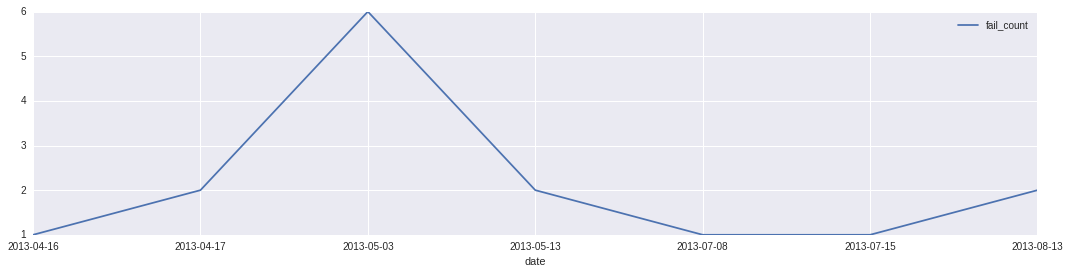

In [27]:
failure_data_for_model_df.plot(x = "date",y = "fail_count",figsize=(18,4))

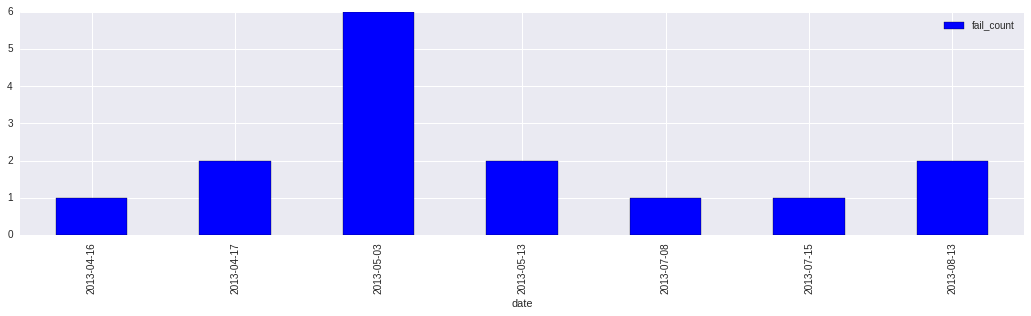

In [28]:
# we see that visualizing the failures using line graph not give us much clarity, using a bar chart will help us
# understand the failures better
failure_data_for_model_df.plot(kind="bar",x = "date",y = "fail_count",figsize=(18,4))

In [29]:
# model vs failures


In [30]:
failure_data_for_models_df = pd.read_sql_query(sql='''SELECT model,count(failure) as fail_count 
                                                    from data where failure = 1
                                                    group by model''',con=engine)

In [31]:
failure_data_for_models_df.head()

,model,fail_count
0,HGST HMS5C4040ALE640,1
1,Hitachi HDS5C3030ALA630,15
2,Hitachi HDS5C4040ALE630,16
3,Hitachi HDS722020ALA330,16
4,Hitachi HDS723020BLA642,1


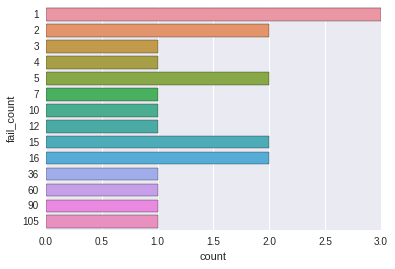

In [32]:
sns.countplot(y='fail_count',data=failure_data_for_models_df)

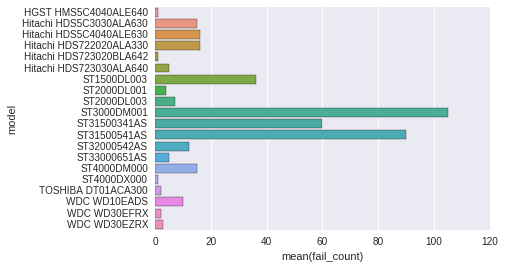

In [33]:
sns.barplot(y='model',x='fail_count',data=failure_data_for_models_df)

In [34]:
# capacity vs failure for 1 model
failure_data_for_model_capacity_df = pd.read_sql_query(sql='''SELECT capacity_bytes,count(failure) as fail_count 
                                                    from data where model = '%s' and failure = 1
                                                    group by date order by date  '''
                                              %(distinct_models.model[0]),con=engine)


In [35]:
failure_data_for_model_capacity_df.head()

,capacity_bytes,fail_count
0,3000592982016,1
1,3000592982016,2
2,3000592982016,6
3,3000592982016,2
4,3000592982016,1


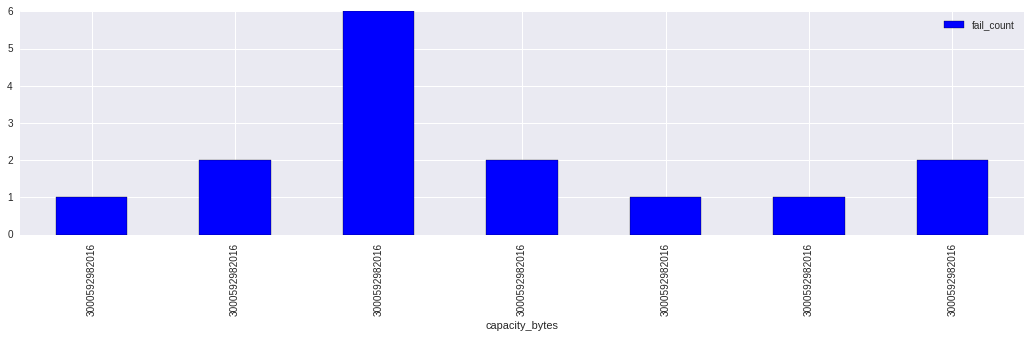

In [36]:
failure_data_for_model_capacity_df.plot(kind="bar",x="capacity_bytes",y="fail_count",figsize=(18,4))

In [40]:
#Exercise 1 : Over time how does the smart_1_raw column change

In [41]:
#Exercise 2 : When a model has failed what are the values of smart_1_raw

# Quantitative - Multi Variable

> Now across all models we are trying to find failures and the capacity_bytes of the hard disk that failed
> Now we are taking the next step in trying to understand the problem not from just one single point of view , but trying to see how many variables add value to the outcome that is failure


In [147]:
failure_data_for_all_model_capacity_df = pd.read_sql_query(sql='''SELECT capacity_bytes,count(failure) as fail_count
                                                                ,model  
                                                    from data where failure = 1
                                                    group by model '''
                                             ,con=engine)

In [123]:
failure_data_for_all_model_capacity_df.describe()

,capacity_bytes,fail_count
count,2.000000e+01,20.000000
mean,2.625520e+12,20.300000
std,9.443481e+11,30.017714
min,1.000205e+12,1.000000
25%,2.000399e+12,2.750000
50%,3.000593e+12,8.500000
75%,3.000593e+12,16.000000
max,4.000787e+12,105.000000


In [119]:
failure_data_for_all_model_capacity_df.head()

,capacity_bytes,fail_count,model
0,4000787030016,1,HGST HMS5C4040ALE640
1,3000592982016,15,Hitachi HDS5C3030ALA630
2,4000787030016,16,Hitachi HDS5C4040ALE630
3,2000398934016,16,Hitachi HDS722020ALA330
4,2000398934016,1,Hitachi HDS723020BLA642


> Now that we have the data stored in a data frame, how can visualize this. Let us try a simple bar chart and see what it looks like

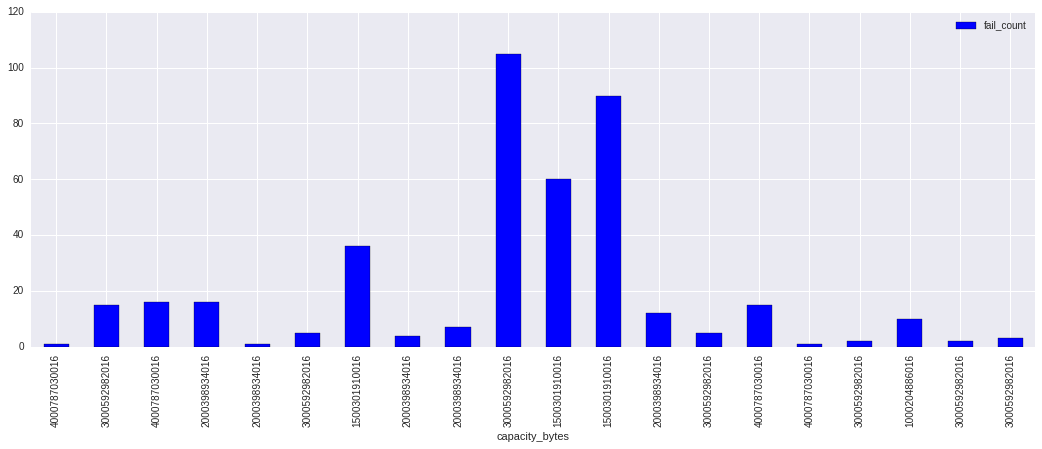

In [46]:
failure_data_for_all_model_capacity_df.plot(x="capacity_bytes",y="fail_count",kind="bar",figsize=(18,6))

### Looking at this chart can you tell what is not being represented right?

 We are having repeated entries for the same capacity and this really does not give us insights on the relation between capacity bytes data and the models. 
 

In [48]:
#Discussion 1: Think of a way you can visualize the above data that can represent this relation 

In [135]:
failure_data_for_all_model_capacity_df.head()

,capacity_bytes,fail_count,model,model_index
0,4000787030016,1,HGST HMS5C4040ALE640,0
1,3000592982016,15,Hitachi HDS5C3030ALA630,1
2,4000787030016,16,Hitachi HDS5C4040ALE630,2
3,2000398934016,16,Hitachi HDS722020ALA330,3
4,2000398934016,1,Hitachi HDS723020BLA642,4


In [149]:
failure_data_for_all_model_capacity_df_pivot = failure_data_for_all_model_capacity_df.pivot("model","capacity_bytes","fail_count")

In [153]:
failure_data_for_all_model_capacity_df_pivot.head()
failure_data_for_all_model_capacity_df_pivot.fillna(0,inplace=True)
failure_data_for_all_model_capacity_df_pivot.head()


capacity_bytes,1000204886016,1500301910016,2000398934016,3000592982016,4000787030016
model,,,,,
HGST HMS5C4040ALE640,0,0,0,0,1
Hitachi HDS5C3030ALA630,0,0,0,15,0
Hitachi HDS5C4040ALE630,0,0,0,0,16
Hitachi HDS722020ALA330,0,0,16,0,0
Hitachi HDS723020BLA642,0,0,1,0,0


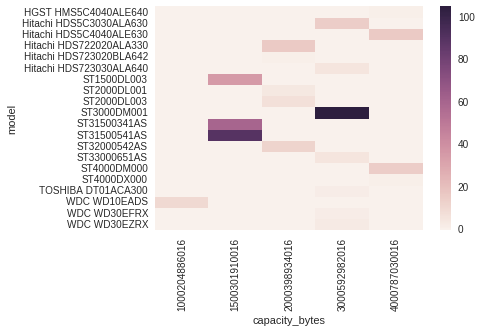

In [156]:
sns.heatmap(failure_data_for_all_model_capacity_df_pivot)

In [ ]:
#Exercice 1: See how the smart columns are related to failure for a one model